In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split  # For any further splits if needed
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import scripts.preprocess as pp
import importlib

In [2]:
# load data

beta_train = pd.read_csv('preprocessing/beta_train_common_sig.csv', index_col=0)  # Assume index is sample IDs
beta_val = pd.read_csv('preprocessing/beta_val_common_sig.csv', index_col=0)
labels_train = pd.read_csv('preprocessing/labels_train_sig.csv', index_col=0)
labels_val = pd.read_csv('preprocessing/labels_val_sig.csv', index_col=0)

# preprocess data
X_train, y_train, X_val, y_val = pp.preprocess_data(beta_train, labels_train, beta_val, labels_val)

Starting preprocessing...
Initial train shape: (1202, 699), val shape: (1202, 80)
Train shape: (699, 1202), Labels unique: [0 1], Counts: [210 489]
Val shape: (80, 1202), Labels unique: [0 1], Counts: [40 40]
Preprocessing complete. X_train mean/std per feature: ~0/1
Sample X_train[0, :5]: [ 0.63741911 -0.84793946 -0.03226355  1.30416555  1.1793446 ]


### Traditional ML

Before SMOTE: [210 489]
After SMOTE : [489 489]
X_train_res shape: (978, 1202)
y_train_res shape: (978,)
After variance filter: 1202 features retained
PCA retained 444 components (0.95 variance)
Number of components to retain 0.95 variance: 352


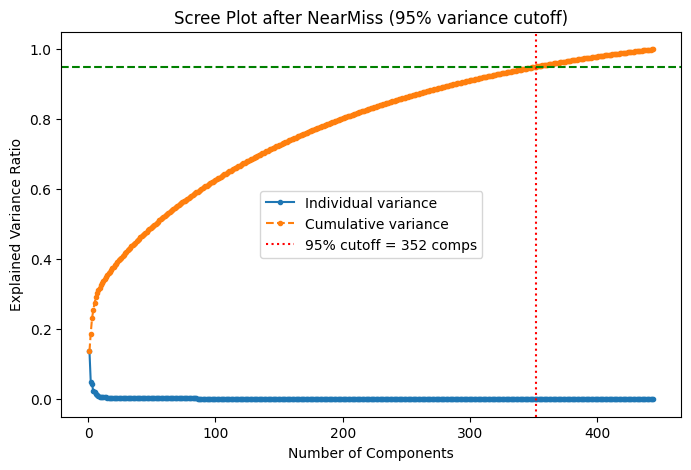

Scree plot saved as: results/plots/PCA_Scree_SMOTE.png


In [3]:
# Apply SMOTE and PCA
X_train_sm, y_train_sm = pp.apply_smote(X_train, y_train)
X_train_sm_pca, X_val_sm_pca = pp.pca_transformation(X_train_sm, X_val, variance_threshold=0.95)

# Plot scree plot for SMOTE
pp.pca_scree_plot(X_train_sm_pca, transformation="SMOTE", threshold=0.95)

Before NearMiss: [210 489]
After NearMiss : [210 210]
X_train_res shape: (420, 1202)
y_train_res shape: (420,)
After variance filter: 1202 features retained
PCA retained 310 components (0.95 variance)
Number of components to retain 0.95 variance: 254


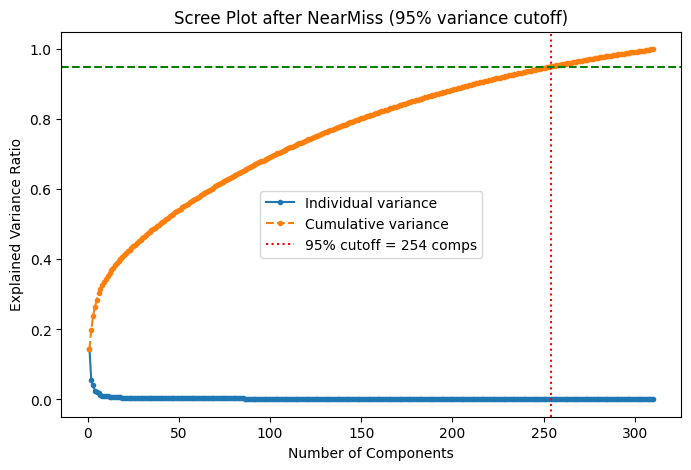

Scree plot saved as: results/plots/PCA_Scree_NearMiss.png


In [4]:
importlib.reload(pp)
# Apply NearMiss and PCA
X_train_nm, y_train_nm = pp.apply_near_miss(X_train, y_train)
X_train_nm_pca, X_val_nm_pca = pp.pca_transformation(X_train_nm, X_val, variance_threshold=0.95)

# Plot scree plot for NearMiss
pp.pca_scree_plot(X_train_nm_pca, transformation="NearMiss", threshold=0.95)

## SVM

In [5]:
import scripts.model_training as ml


# Train and evaluate SVM on SMOTE data
best_svm_sm, svm_search_sm = ml.train_svm(X_train_sm_pca, y_train_sm, transformation="SMOTE")

Starting SVM training with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/adhiraj/miniconda3/envs/mir_comp/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.6s
[CV] END C=1.6599452033620266, gamma=0.005983876860868068, kernel=linear; total time=   0.6s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.6s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.7s
[CV] END C=1.6599452033620266, gamma=0.005983876860868068, kernel=linear; total time=   0.6s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.7s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total time=   1.7s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total time=   1.7s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   2.2s
[CV] END C=1.6599452033620266, gamma=0.005983876860868068, kernel=linear; total time=   2.0s
[CV] END C=1.6599452033620266, gamma=0.005983876860868068, kernel=linear; total time=   2.0s

In [6]:
# Validate on validation set
svm_sm_performance = ml.model_validation(best_svm_sm, X_val_sm_pca, y_val, model_name = "SVM_SMOTE")

Validation results for SVM_SMOTE:
  TN: 13
  FP: 27
  FN: 1
  TP: 39
  accuracy: 0.6500
  precision: 0.5909
  recall: 0.9750
  specificity: 0.3250
  f1: 0.7358
  mcc: 0.3948
  roc_auc: 0.7775
  pr_auc: 0.6686


In [7]:
# SVM on NearMiss data
best_svm_nm, svm_search_nm = ml.train_svm(X_train_nm_pca, y_train_nm, transformation="NearMiss")

Starting SVM training with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.1s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.1s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.2s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.2s
[CV] END C=7.896910002727692, gamma=0.09084469696321254, kernel=linear; total time=   0.2s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total time=   0.2s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total time=   0.2s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total time=   0.2s
[CV] END C=1.6599452033620266, gamma=0.005983876860868068, kernel=linear; total time=   0.2s
[CV] END C=3.845401188473625, gamma=0.3010121430917521, kernel=rbf; total tim

In [8]:
# Validation on validation set
svm_nm_performance = ml.model_validation(best_svm_nm, X_val_nm_pca, y_val, model_name = "SVM_NearMiss")

Validation results for SVM_NearMiss:
  TN: 34
  FP: 6
  FN: 36
  TP: 4
  accuracy: 0.4750
  precision: 0.4000
  recall: 0.1000
  specificity: 0.8500
  f1: 0.1600
  mcc: -0.0756
  roc_auc: 0.4244
  pr_auc: 0.4569


## RF

In [9]:
importlib.reload(ml)
# Train and evaluate Random Forest on SMOTE data
best_rf_sm, rf_search_sm = ml.train_rf(X_train_sm_pca, y_train_sm, transformation="SMOTE")

Starting Random Forest training with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.5s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.4s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   9.0s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   9.3s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   9.3s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=413; total time=   8.5s
[CV] END bootstrap=False, max_depth=34, max_features=log2, 

In [37]:
# Validate on validation set

rf_smote_performance = ml.model_validation(best_rf_sm, X_val_sm_pca, y_val, model_name = "RF_SMOTE")

Validation results for RF_SMOTE:
  TN: 0
  FP: 40
  FN: 0
  TP: 40
  accuracy: 0.5000
  precision: 0.5000
  recall: 1.0000
  specificity: 0.0000
  f1: 0.6667
  mcc: 0.0000
  roc_auc: 0.6319
  pr_auc: 0.5977


In [38]:
# RF on NearMiss data
best_rf_nm, rf_search_nm = ml.train_rf(X_train_nm_pca, y_train_nm, transformation="NearMiss")

Starting Random Forest training with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   1.8s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   1.9s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   7.7s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   7.9s
[CV] END bootstrap=False, max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   4.4s
[CV] END bootstrap=True, max_depth=33, max_features=None, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   8.0s
[CV] END bootstrap=True, max_depth=33, max_features=None, mi

In [39]:
# Validate RF on validation set
rf_nm_performance = ml.model_validation(best_rf_nm, X_val_nm_pca, y_val, model_name = "RF_NearMiss")

Validation results for RF_NearMiss:
  TN: 3
  FP: 37
  FN: 18
  TP: 22
  accuracy: 0.3125
  precision: 0.3729
  recall: 0.5500
  specificity: 0.0750
  f1: 0.4444
  mcc: -0.4261
  roc_auc: 0.1481
  pr_auc: 0.3382


### Deep Learning

In [11]:
import random
import os
# Set random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # If using GPU
os.environ['PYTHONHASHSEED'] = str(random_seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
importlib.reload(ml)
# SMOTE DL hyperparameter tuning
best_dl_sm_params = ml.train_optuna(X_train_sm_pca, y_train_sm, transformation="SMOTE", n_trials=50)

[I 2025-10-09 08:21:13,594] A new study created in memory with name: no-name-63303dd0-baee-470f-870f-9669f56ade4a
[I 2025-10-09 08:21:18,415] Trial 0 finished with value: 0.8097906855049711 and parameters: {'hidden_dim': 192, 'dropout': 0.5, 'learning_rate': 0.001570297088405539, 'batch_size': 16}. Best is trial 0 with value: 0.8097906855049711.
[I 2025-10-09 08:21:22,082] Trial 1 finished with value: 0.8190423861852432 and parameters: {'hidden_dim': 32, 'dropout': 0.5, 'learning_rate': 0.0006358358856676254, 'batch_size': 64}. Best is trial 1 with value: 0.8190423861852432.
[I 2025-10-09 08:21:35,292] Trial 2 finished with value: 0.8200732600732602 and parameters: {'hidden_dim': 448, 'dropout': 0.1, 'learning_rate': 3.511356313970405e-05, 'batch_size': 64}. Best is trial 2 with value: 0.8200732600732602.
[I 2025-10-09 08:21:37,161] Trial 3 finished with value: 0.8343694400837258 and parameters: {'hidden_dim': 224, 'dropout': 0.1, 'learning_rate': 0.000684792009557478, 'batch_size': 64


CV Results (Scikit-learn style):
 mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_hidden_dim  param_dropout  param_learning_rate  param_batch_size                                                                                                         params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
      0.954675      0.062660         0.001510        0.000459               192            0.5             0.001570                16                   {'hidden_dim': 192, 'dropout': 0.5, 'learning_rate': 0.001570297088405539, 'batch_size': 16}           0.836735           0.801020           0.816327           0.774359           0.820513         0.809791        0.021052               41
      0.728894      0.095751         0.001107        0.000166                32            0.5             0.000636                64                   {'hidden_dim': 32, 'dropout': 0.5,

In [50]:
importlib.reload(ml)

# Model training with best hyperparameters and evaluation

dl_sm_performance = ml.optuna_validation(X_train_sm_pca, y_train_sm, X_val_sm_pca, y_val, best_dl_sm_params, transformation="SMOTE")


Validating MLP with best hyperparameters on validation set...
Epoch 1, Validation Loss: 0.5317
Epoch 2, Validation Loss: 0.4994
Epoch 3, Validation Loss: 0.4117
Epoch 4, Validation Loss: 0.3774
Epoch 5, Validation Loss: 0.4106
Epoch 6, Validation Loss: 0.3154
Epoch 7, Validation Loss: 0.3502
Epoch 8, Validation Loss: 0.3619
Epoch 9, Validation Loss: 0.3635
Epoch 10, Validation Loss: 0.3369
Epoch 11, Validation Loss: 0.3433
Early stopping triggered
Validation results for MLP:
  TN: 36
  FP: 4
  FN: 3
  TP: 37
  accuracy: 0.9125
  precision: 0.9024
  recall: 0.9250
  specificity: 0.9000
  f1: 0.9136
  mcc: 0.8253
  roc_auc: 0.9556
  pr_auc: 0.9573


In [27]:
# NM DL hyperparameter tuning
importlib.reload(ml)

best_dl_nm_params = ml.train_optuna(X_train_nm_pca, y_train_nm, transformation="NM", n_trials=10)

[I 2025-10-09 08:53:54,601] A new study created in memory with name: no-name-3c38c39d-7bc6-46d6-b003-99bdb6e302d7


[I 2025-10-09 08:53:55,859] Trial 0 finished with value: 0.6976190476190476 and parameters: {'hidden_dim': 192, 'dropout': 0.5, 'learning_rate': 0.001570297088405539, 'batch_size': 16}. Best is trial 0 with value: 0.6976190476190476.
[I 2025-10-09 08:53:56,994] Trial 1 finished with value: 0.6857142857142857 and parameters: {'hidden_dim': 32, 'dropout': 0.5, 'learning_rate': 0.0006358358856676254, 'batch_size': 64}. Best is trial 0 with value: 0.6976190476190476.
[I 2025-10-09 08:54:00,339] Trial 2 finished with value: 0.6642857142857143 and parameters: {'hidden_dim': 448, 'dropout': 0.1, 'learning_rate': 3.511356313970405e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6976190476190476.
[I 2025-10-09 08:54:01,118] Trial 3 finished with value: 0.6880952380952381 and parameters: {'hidden_dim': 224, 'dropout': 0.1, 'learning_rate': 0.000684792009557478, 'batch_size': 64}. Best is trial 0 with value: 0.6976190476190476.
[I 2025-10-09 08:54:06,182] Trial 4 finished with value: 0.6761


CV Results (Scikit-learn style):
 mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_hidden_dim  param_dropout  param_learning_rate  param_batch_size                                                                                         params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
      0.248658      0.031634         0.000803        0.000089               192            0.5             0.001570                16   {'hidden_dim': 192, 'dropout': 0.5, 'learning_rate': 0.001570297088405539, 'batch_size': 16}           0.738095           0.630952           0.714286           0.702381           0.702381         0.697619        0.035794                1
      0.224814      0.037509         0.000753        0.000215                32            0.5             0.000636                64   {'hidden_dim': 32, 'dropout': 0.5, 'learning_rate': 0.0006358358856676254, 'batch_

In [28]:
dl_nm_performance = ml.optuna_validation(X_train_nm_pca, y_train_nm, X_val_nm_pca, y_val, best_dl_nm_params, transformation="NM")


Validating MLP with best hyperparameters on validation set...
Epoch 1, Validation Loss: 0.8904
Epoch 2, Validation Loss: 1.2373
Epoch 3, Validation Loss: 0.9552
Epoch 4, Validation Loss: 1.1534
Epoch 5, Validation Loss: 1.1789
Epoch 6, Validation Loss: 0.8898
Epoch 7, Validation Loss: 1.1510
Epoch 8, Validation Loss: 1.0907
Epoch 9, Validation Loss: 1.4427
Epoch 10, Validation Loss: 1.7343
Epoch 11, Validation Loss: 2.0525
Early stopping triggered
Validation results for MLP:
  TN: 15
  FP: 25
  FN: 6
  TP: 34
  accuracy: 0.6125
  precision: 0.5763
  recall: 0.8500
  specificity: 0.3750
  f1: 0.6869
  mcc: 0.2557
  roc_auc: 0.7050
  pr_auc: 0.6449


In [30]:
# load xgb model
import joblib

xgb_sm = joblib.load('results/models/xgb_best_xgb_model_sm_refined.pkl')
xgb_nm = joblib.load('results/models/xgb_best_xgb_model_nm_refined.pkl')

/home/adhiraj/miniconda3/envs/mir_comp/lib/python3.13/pickle.py:1760: UserWarning: [09:49:39] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [49]:
import xgboost as xgb

# Validate XGB models
xgb_sm_performance = ml.model_validation(xgb_sm, X_val_sm_pca, y_val, model_name = "XGB_SMOTE")


Validation results for XGB_SMOTE:
  TN: 7
  FP: 33
  FN: 3
  TP: 37
  accuracy: 0.5500
  precision: 0.5286
  recall: 0.9250
  specificity: 0.1750
  f1: 0.6727
  mcc: 0.1512
  roc_auc: 0.5913
  pr_auc: 0.5672


In [32]:
xgb_nm_performance = ml.model_validation(xgb_nm, X_val_nm_pca, y_val, model_name = "XGB_NearMiss")

Validation results for XGB_NearMiss:
  TN: 29
  FP: 11
  FN: 18
  TP: 22
  accuracy: 0.6375
  precision: 0.6667
  recall: 0.5500
  specificity: 0.7250
  f1: 0.6027
  mcc: 0.2793
  roc_auc: 0.6931
  pr_auc: 0.6447


In [51]:
dl_sm_performance

{'model': 'MLP',
 'TN': np.int64(36),
 'FP': np.int64(4),
 'FN': np.int64(3),
 'TP': np.int64(37),
 'accuracy': 0.9125,
 'precision': 0.9024390243902439,
 'recall': 0.925,
 'specificity': np.float64(0.9),
 'f1': 0.9135802469135802,
 'mcc': 0.8252579334125864,
 'roc_auc': 0.9556250000000001,
 'pr_auc': 0.9572533144477207,
 'roc_curve': (array([0.   , 0.   , 0.   , 0.025, 0.025, 0.075, 0.075, 0.225, 0.225,
         0.4  , 0.4  , 1.   ]),
  array([0.   , 0.025, 0.475, 0.475, 0.775, 0.775, 0.925, 0.925, 0.95 ,
         0.95 , 1.   , 1.   ])),
 'pr_curve': (array([0.5       , 0.50632911, 0.51282051, 0.51948052, 0.52631579,
         0.53333333, 0.54054054, 0.54794521, 0.55555556, 0.56338028,
         0.57142857, 0.57971014, 0.58823529, 0.59701493, 0.60606061,
         0.61538462, 0.625     , 0.63492063, 0.64516129, 0.6557377 ,
         0.66666667, 0.6779661 , 0.68965517, 0.70175439, 0.71428571,
         0.70909091, 0.7037037 , 0.71698113, 0.73076923, 0.74509804,
         0.76      , 0.775510

In [52]:
# collect all performance metrics
all_performances = {
    "SVM_SMOTE": svm_sm_performance,
    "SVM_NearMiss": svm_nm_performance,
    "RF_SMOTE": rf_smote_performance,
    "RF_NearMiss": rf_nm_performance,
    "DL_SMOTE": dl_sm_performance,
    "DL_NearMiss": dl_nm_performance,
    "XGB_SMOTE": xgb_sm_performance,
    "XGB_NearMiss": xgb_nm_performance
}
all_performances

{'SVM_SMOTE': {'model': 'SVM_SMOTE',
  'TN': np.int64(13),
  'FP': np.int64(27),
  'FN': np.int64(1),
  'TP': np.int64(39),
  'accuracy': 0.65,
  'precision': 0.5909090909090909,
  'recall': 0.975,
  'specificity': np.float64(0.325),
  'f1': 0.7358490566037735,
  'mcc': 0.39477101697586137,
  'roc_auc': 0.7775,
  'pr_auc': 0.668557801046894,
  'roc_curve': (array([0.   , 0.025, 0.05 , 0.05 , 0.1  , 0.1  , 0.125, 0.125, 0.15 ,
          0.15 , 0.175, 0.175, 0.2  , 0.2  , 0.225, 0.225, 0.25 , 0.25 ,
          0.275, 0.275, 0.3  , 0.3  , 0.325, 0.325, 0.35 , 0.35 , 0.375,
          0.375, 0.4  , 0.4  , 0.45 , 0.45 , 0.7  , 0.7  , 1.   ]),
   array([0.   , 0.   , 0.   , 0.025, 0.025, 0.275, 0.275, 0.325, 0.325,
          0.35 , 0.35 , 0.425, 0.425, 0.5  , 0.5  , 0.55 , 0.55 , 0.725,
          0.725, 0.8  , 0.8  , 0.825, 0.825, 0.85 , 0.85 , 0.875, 0.875,
          0.9  , 0.9  , 0.95 , 0.95 , 0.975, 0.975, 1.   , 1.   ])),
  'pr_curve': (array([0.5       , 0.50632911, 0.51282051, 0.51948052

In [53]:
all_performances_df = pd.DataFrame(all_performances).T
all_performances_df

,model,TN,FP,FN,TP,accuracy,precision,recall,specificity,f1,mcc,roc_auc,pr_auc,roc_curve,pr_curve
SVM_SMOTE,SVM_SMOTE,13,27,1,39,0.65,0.590909,0.975,0.325,0.735849,0.394771,0.7775,0.668558,"([0.0, 0.025, 0.05, 0.05, 0.1, 0.1, 0.125, 0.1...","([0.5, 0.5063291139240507, 0.5128205128205128,..."
SVM_NearMiss,SVM_NearMiss,34,6,36,4,0.475,0.4,0.1,0.85,0.16,-0.075593,0.424375,0.456929,"([0.0, 0.025, 0.075, 0.075, 0.15, 0.15, 0.225,...","([0.5, 0.4936708860759494, 0.48717948717948717..."
RF_SMOTE,RF_SMOTE,0,40,0,40,0.5,0.5,1.0,0.0,0.666667,0.0,0.631875,0.597746,"([0.0, 0.0, 0.075, 0.075, 0.1, 0.1, 0.125, 0.1...","([0.5, 0.5063291139240507, 0.5, 0.506493506493..."
RF_NearMiss,RF_NearMiss,3,37,18,22,0.3125,0.372881,0.55,0.075,0.444444,-0.426143,0.148125,0.338181,"([0.0, 0.025, 0.225, 0.225, 0.575, 0.575, 0.62...","([0.5, 0.5063291139240507, 0.5, 0.493506493506..."
DL_SMOTE,MLP,36,4,3,37,0.9125,0.902439,0.925,0.9,0.91358,0.825258,0.955625,0.957253,"([0.0, 0.0, 0.0, 0.025, 0.025, 0.075, 0.075, 0...","([0.5, 0.5063291139240507, 0.5128205128205128,..."
DL_NearMiss,MLP,15,25,6,34,0.6125,0.576271,0.85,0.375,0.686869,0.255686,0.705,0.644914,"([0.0, 0.025, 0.025, 0.05, 0.05, 0.1, 0.1, 0.1...","([0.5, 0.5063291139240507, 0.5128205128205128,..."
XGB_SMOTE,XGB_SMOTE,7,33,3,37,0.55,0.528571,0.925,0.175,0.672727,0.151186,0.59125,0.567192,"([0.0, 0.0, 0.0, 0.05, 0.05, 0.175, 0.175, 0.2...","([0.5, 0.5063291139240507, 0.5128205128205128,..."
XGB_NearMiss,XGB_NearMiss,29,11,18,22,0.6375,0.666667,0.55,0.725,0.60274,0.27931,0.693125,0.644663,"([0.0, 0.025, 0.025, 0.05, 0.05, 0.075, 0.075,...","([0.5, 0.5063291139240507, 0.5128205128205128,..."


In [55]:
# save performance metrics to csv
all_performances_df.to_csv('results/model_performance_summary_sig.csv')